# PML Project

Date: 2022-01-10

Author: Xiqing Mao

Content: Dirichlet Prior

In [1]:
%%capture
!wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta    
!wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
!pip install biopython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import helper
import numpy as np
import torch
from torch.optim import Adam
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.manifold import TSNE

In [3]:
DEVICE = 'cuda'
batch_size = 16

In [10]:
dataset, weights = helper.get_data('BLAT_ECOLX_1_b0.5_labeled.fasta', calc_weights=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_weighted = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.sampler.WeightedRandomSampler(weights, num_samples=len(dataset)))

In [5]:
def update_alpha(p):
    N = p.shape[0]
    mu_tilde_1 = torch.mean(p ** 1, dim=0) 
    mu_tilde_2 = torch.mean(p ** 2, dim=0)
    S = (mu_tilde_1 - mu_tilde_2) / (mu_tilde_2 - mu_tilde_1 ** 2)
    S = torch.mean(S)
    alpha = S / N * torch.sum(p, dim=0)
    return alpha.to(DEVICE)

In [15]:
class dirichlet_VAE(nn.Module):
    def __init__(self, input_size, latent_size, device):
        super().__init__()
        self.fc11 = nn.Linear(input_size, 1500)
        self.fc12 = nn.Linear(1500, 1500)
        self.fc131 = nn.Linear(1500, latent_size)
        self.fc132 = nn.Linear(1500, latent_size)

        self.fc21 = nn.Linear(latent_size, 100)
        self.fc22 = nn.Linear(100, 2000)
        self.fc23 = nn.Linear(2000, input_size)
        
        self.device = device
        self.latent_size = latent_size

    def encoder(self, x):
        x = nn.functional.one_hot(x, num_classes=23).float().reshape(x.shape[0], -1)
        hidden = nn.ReLU()(self.fc11(x))
        hidden = nn.ReLU()(self.fc12(hidden))
        alpha_hat = self.fc131(hidden)
        return nn.Softplus()(alpha_hat)
    
    def decoder(self, z):
        hidden = nn.ReLU()(self.fc21(z))
        hidden = nn.ReLU()(self.fc22(hidden))
        x = self.fc23(hidden)
        return x.reshape(z.shape[0], -1, 23)
    
    def forward(self, x, alpha, mc_samples=1):   
        # x ---> alpha_hat
        alpha_hat = self.encoder(x)
        # # sample auxiliary variable u
        # u = torch.FloatTensor(batch_size, self.latent_size).uniform_(0, 1).to(self.device)
        # # inverse CDF
        # v = torch.pow(u * alpha_hat * torch.exp(torch.lgamma(alpha_hat)), 1./alpha_hat)
        # # normalization
        # z = torch.div(v, torch.reshape(torch.sum(v,1), (-1, 1)))
        z = torch.distributions.dirichlet.Dirichlet(alpha_hat).rsample()
        
        diff = alpha_hat - alpha
        KL_post_prior = torch.sum(torch.lgamma(alpha) - torch.lgamma(alpha_hat) + diff * torch.digamma(alpha_hat), dim=-1)

        # KL_post_prior = torch.distributions.kl.kl_divergence(torch.distributions.dirichlet.Dirichlet(alpha_hat), \
        #                                                      torch.distributions.dirichlet.Dirichlet(alpha)).reshape(-1)
        
        x_logit = self.decoder(z) 

        Ep = torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1)
        for sample in range(mc_samples-1):
            z = torch.distributions.dirichlet.Dirichlet(alpha_hat).rsample()
            x_logit = self.decoder(z)
            Ep += torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1)
        Ep = Ep / mc_samples
        ELBO = torch.sum(Ep - KL_post_prior)
        
        #print(ELBO)
        return ELBO, alpha_hat, z

In [16]:
def train(model, dl, optimizer, device, alpha, p=None, update=False):
    ELBOs = []
    Zs = []
    for i in dl:
        optimizer.zero_grad()
        if update:
            alpha_new = update_alpha(p)
        else:
            alpha_new = alpha
        if torch.any(alpha_new > 1e3):
            alpha_new = alpha
        alpha = alpha_new
        ELBO, _, z = model(i[0].to(device),alpha, 1)
        loss = -ELBO
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        #print(torch.sum(dirichlet_vae.fc11.weight.grad) if dirichlet_vae.fc11.weight.grad is not None else 0)
        #print(ELBO, z)
        optimizer.step()
        ELBOs.append(ELBO.item())
        Zs.append(z.clone().detach())
    Zs = torch.cat(Zs, dim=0)
    return sum(ELBOs) / len(ELBOs), alpha, Zs

In [17]:
# train the model
latent_size = 200
input_size = next(iter(dataloader_weighted))[0].shape[1] * 23
DEVICE = "cuda"
dirichlet_vae = dirichlet_VAE(input_size, latent_size, device=DEVICE).to(DEVICE)
alpha = torch.full([1, latent_size], 0.99).to(DEVICE)
EPOCH = 180
ELBOs = []
z = None
for epoch in tqdm(range(EPOCH)):
    if epoch in range(999, 1000, 1):  #no update
        elbo, alpha, z = train(dirichlet_vae, dataloader_weighted, Adam(dirichlet_vae.parameters(), lr=0.0001), DEVICE, alpha, p=z[np.random.randint(0, z.shape[0], 10), :], update=True)
    else:   
        elbo, alpha, z = train(dirichlet_vae, dataloader_weighted, Adam(dirichlet_vae.parameters(), lr=0.0001), DEVICE, alpha)
    ELBOs.append(elbo)

100%|██████████| 180/180 [12:32<00:00,  4.18s/it]


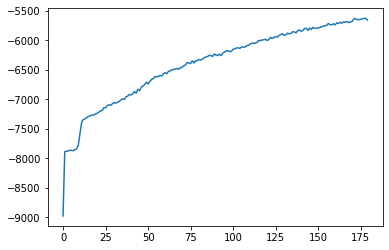

In [19]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs)
plt.show()

In [20]:
Zs = []
labels = []
with torch.no_grad():
    for i in dataloader:
        z_mu = dirichlet_vae.encoder((i[0].to(DEVICE))) - 1 
        Zs.append(z_mu.cpu() / torch.sum(z_mu.cpu(), dim=-1, keepdim=True)) # mode
        labels.append(i[1])
Zs = torch.cat(Zs).numpy()
labels = torch.cat(labels).numpy()
Zs = TSNE(2).fit_transform(Zs)

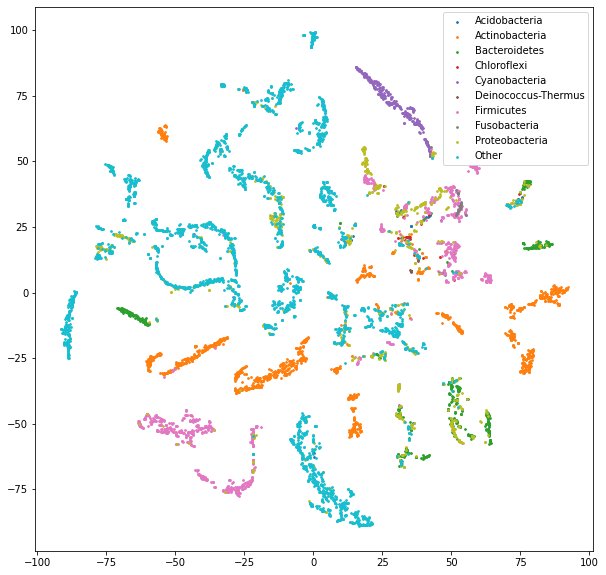

In [22]:
plt.rcParams["figure.figsize"] = (10, 10)
for idx, name in enumerate(helper.phyla[:]):
    plt.scatter(Zs[labels == idx, 0], Zs[labels == idx, 1], s=3, label=name)
plt.legend()
plt.show()

In [23]:
# Check the reconstruct accuracy (make sure it learns normally)
acc = []
for i in range(len(dataset)):
    raw_sequence = dataset[i][0][np.newaxis, :].to(DEVICE)
    z_mu = dirichlet_vae.encoder(raw_sequence) - 1
    p = z_mu / torch.sum(z_mu, dim=-1, keepdim=True) # mode
    acc.append(torch.argmax(dirichlet_vae.decoder(p), dim=-1) == raw_sequence)
acc = np.mean(torch.cat(acc, dim=0).cpu().numpy())
print("Reconstruct Accuracy:", acc)

Reconstruct Accuracy: 0.5645112972934194


In [24]:
experimental_data = helper.read_experimental_data("BLAT_ECOLX_Ranganathan2015.csv", dataset)

In [28]:
raw_sequence = dataset[0][0][np.newaxis, :].to(DEVICE)
experiment_value = []
predicted_value = []
with torch.no_grad():
    log_x_wt_ELBO, _, _ = dirichlet_vae(raw_sequence, alpha, 100)
    for (position, mutant_from), row in tqdm(experimental_data.iterrows()):
        assert helper.aa1_to_index[mutant_from] == raw_sequence[0, position]
        for mutant_to, exp_value in row.iteritems():
            if mutant_to != mutant_from:
                new_sequence = raw_sequence.clone()
                new_sequence[0, position] = helper.aa1_to_index[mutant_to]
                experiment_value.append(exp_value)
                log_x_mt_ELBO, _, _ = dirichlet_vae(new_sequence, alpha, 100)
                predicted_value.append((log_x_mt_ELBO - log_x_wt_ELBO).item())

263it [06:52,  1.57s/it]


In [29]:
spearmanr(experiment_value, predicted_value)

SpearmanrResult(correlation=0.6644857343435555, pvalue=0.0)